In [6]:
!pip install prophet


In [41]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 8.8 MB/s eta 0:00:09
   - -------------------------------------- 2.6/72.0 MB 7.6 MB/s eta 0:00:10
   - -------------------------------------- 3.1/72.0 MB 6.6 MB/s eta 0:00:11
   -- ------------------------------------- 3.7/72.0 MB 4.7 MB/s eta 0:00:15
   -- ------------------------------------- 3.9/72.0 MB 4.5 MB/s eta 0:00:16
   -- ------------------------------------- 4.5/72.0 MB 3.7 MB/s eta 0:00:19
   -- ------------------------------------- 4.7/72.0 MB 3.5 MB/s eta 0:00:20
   -- ------------------------------------- 5.2/72.0 MB 3.2 MB/s eta 0:00:21
   --- ------------------------------------ 5.8/72.0 MB 3.1 MB/s eta 0:00:22
   --- ------------------------------------ 6.3/72.0 MB 3.1 MB/s eta 0:00:22
   --- ------------------------------------ 6.8/72.0 MB 3.0 MB/s eta 0:00:22
   ---- ----------------------------------- 7.3/72.0 MB 3.0 MB/s eta 0:00:22
   ---

In [66]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [51]:
df = pd.read_csv("final.csv")

print("Columns:", df.columns.tolist())
df.head()

# Remove duplicates
df = df.drop_duplicates()
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

date_cols = ["posting_date", "application_deadline"]

# Convert to datetime
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

for col in date_cols:
    median_dt = df[col].median()
    df[col] = df[col].fillna(median_dt)


for col in df.columns:
    if col not in date_cols:
        if df[col].dtype == "object":
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())


# Strip whitespace
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

print("After cleaning:")
df.head()

Columns: ['job_title', 'salary_usd', 'salary_currency', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'remote_ratio', 'required_skills', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'job_description_length', 'benefits_score', 'company_name']
After cleaning:


,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,NLP Engineer,138149,EUR,EX,FT,France,M,France,100,"Linux, R, PyTorch, Scala, Hadoop",Master,19,Consulting,2024-02-14,2024-03-11,1656,10.0,DeepTech Ventures
1,Autonomous Systems Engineer,125926,AUD,MI,FT,Australia,L,Australia,50,"Spark, Python, Mathematics, TensorFlow, Data V...",PhD,2,Gaming,2025-03-11,2025-04-16,1021,8.7,Autonomous Tech
2,ML Ops Engineer,104568,EUR,SE,FT,Germany,S,France,50,"Deep Learning, TensorFlow, NLP, Java, Azure",PhD,8,Automotive,2025-02-02,2025-03-29,2441,8.7,Advanced Robotics
3,Principal Data Scientist,51562,USD,EN,FL,Sweden,S,Sweden,100,"Java, TensorFlow, MLOps, Linux",Bachelor,0,Healthcare,2024-11-28,2025-01-19,1448,9.0,Cloud AI Solutions
4,AI Software Engineer,66137,CAD,MI,FL,Canada,S,Italy,0,"Kubernetes, AWS, Azure",PhD,3,Real Estate,2024-02-23,2024-04-28,508,5.8,DeepTech Ventures


In [52]:
# Define keywords
ai_keywords = [
    "machine learning", "ml", "deep learning", "ai", "artificial intelligence",
    "data science", "nlp", "computer vision", "cv", "neural network",
    "model training", "llm", "large language model", "gen ai", "generative ai"
]

def is_ai_positive(text):
    if isinstance(text, str):
        text = text.lower()
        return any(keyword in text for keyword in ai_keywords)
    return False

# Apply detection to job_title + required_skills
df["ai_positive_title"] = df["job_title"].apply(is_ai_positive)
df["ai_positive_skills"] = df["required_skills"].apply(is_ai_positive)


df["ai_impact_label"] = (
    df["ai_positive_title"] | df["ai_positive_skills"]
).astype(int)

print(df["ai_impact_label"].value_counts())

ai_impact_label
1    12335
0     2665
Name: count, dtype: int64


In [53]:

# Encode categorical columns that exist
categorical_cols = [
    "job_title", "salary_currency", "experience_level", "employment_type",
    "company_location", "company_size", "employee_residence",
    "education_required", "industry", "company_name"
]

label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le





In [54]:
# Convert required_skills to a binary bag-of-words
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(","))
skills_matrix = vectorizer.fit_transform(df["required_skills"])

skills_df = pd.DataFrame(
    skills_matrix.toarray(),
    columns=[f"skill_{s}" for s in vectorizer.get_feature_names_out()]
)

df = pd.concat([df.drop(columns=["required_skills"]), skills_df], axis=1)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [55]:
# Date features
df["posting_year"] = df["posting_date"].dt.year
df["posting_month"] = df["posting_date"].dt.month
df["deadline_days"] = (df["application_deadline"] - df["posting_date"]).dt.days

df = df.drop(columns=["application_deadline", "job_title"])


In [56]:
# Use ai_impact_label created earlier 
y = df["ai_impact_label"]

# Drop helper columns + anything that would leak information
X = df.drop(columns=[
    "ai_impact_label",
    "ai_positive_title",
    "ai_positive_skills",
    "required_skills",
    "salary_usd",
    "job_id"
], errors="ignore")

print("X shape:", X.shape)
print("y distribution:", y.value_counts())


for col in X.columns:
    if np.issubdtype(X[col].dtype, np.datetime64):
        print("DROPPING datetime column:", col)
        X = X.drop(columns=[col])


X shape: (15000, 65)
y distribution: ai_impact_label
1    12335
0     2665
Name: count, dtype: int64
DROPPING datetime column: posting_date



=== Logistic Regression ===
Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       673
           1       0.82      1.00      0.90      3077

    accuracy                           0.82      3750
   macro avg       0.41      0.50      0.45      3750
weighted avg       0.67      0.82      0.74      3750


=== Random Forest ===
Accuracy: 0.8208
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       673
           1       0.82      1.00      0.90      3077

    accuracy                           0.82      3750
   macro avg       0.91      0.50      0.45      3750
weighted avg       0.85      0.82      0.74      3750



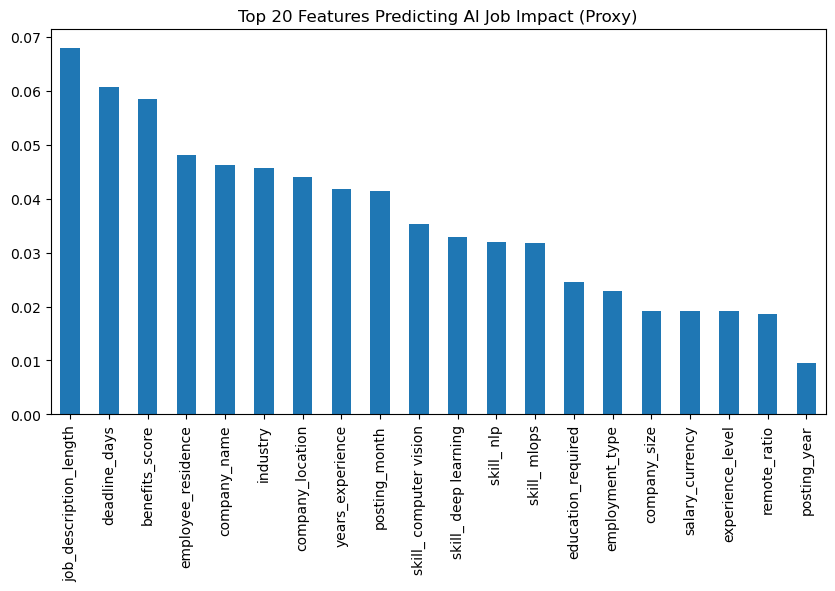

In [57]:
# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



# LOGISTIC REGRESSION
log_reg = make_pipeline(
    StandardScaler(with_mean=False),   # with_mean=False required for sparse matrices
    LogisticRegression(max_iter=5000, solver="lbfgs")
)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


# 8. RANDOM FOREST
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


# FEATURE IMPORTANCE
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,5))
top_20.plot(kind="bar")
plt.title("Top 20 Features Predicting AI Job Impact (Proxy)")
plt.show()


=== XGBoost Classifier ===
Accuracy: 0.8125333333333333
              precision    recall  f1-score   support

           0       0.31      0.04      0.06       673
           1       0.82      0.98      0.90      3077

    accuracy                           0.81      3750
   macro avg       0.57      0.51      0.48      3750
weighted avg       0.73      0.81      0.75      3750



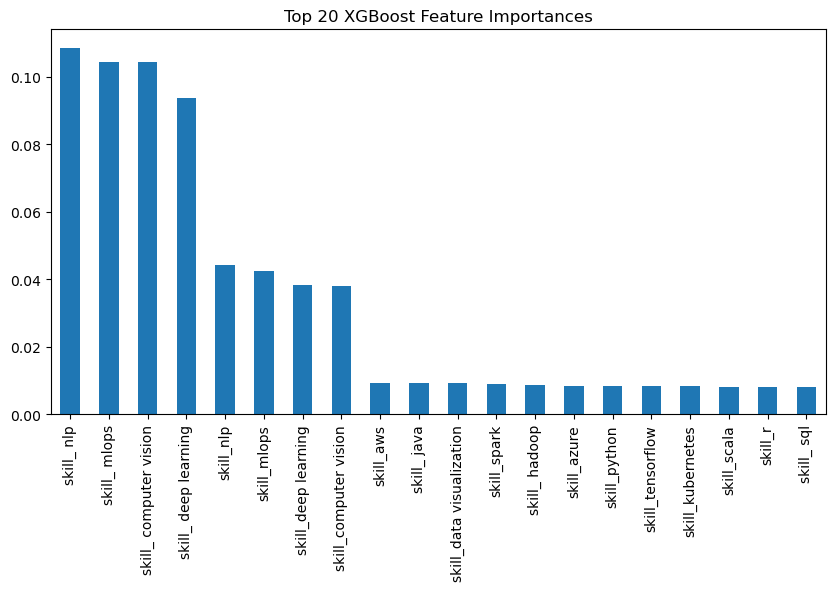

In [58]:
# XGBOOST CLASSIFIER

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# Train model
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Results
print("\n=== XGBoost Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))



xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns)
top_20_xgb = xgb_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,5))
top_20_xgb.plot(kind="bar")
plt.title("Top 20 XGBoost Feature Importances")
plt.show()

In [59]:
from sklearn.linear_model import LogisticRegression

# Get base model predictions

rf_train_pred = rf.predict(X_train)
xgb_train_pred = xgb.predict(X_train)

stack_train = np.column_stack((rf_train_pred, xgb_train_pred))

rf_test_pred = rf.predict(X_test)
xgb_test_pred = xgb.predict(X_test)

stack_test = np.column_stack((rf_test_pred, xgb_test_pred))


# Train the meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stack_train, y_train)

# Final stacked model predictions
stacked_pred = meta_model.predict(stack_test)


print("\n=== STACKED MODEL (Random Forest + XGBoost) ===")
print("Accuracy:", accuracy_score(y_test, stacked_pred))
print(classification_report(y_test, stacked_pred))



=== STACKED MODEL (Random Forest + XGBoost) ===
Accuracy: 0.8208
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       673
           1       0.82      1.00      0.90      3077

    accuracy                           0.82      3750
   macro avg       0.91      0.50      0.45      3750
weighted avg       0.85      0.82      0.74      3750



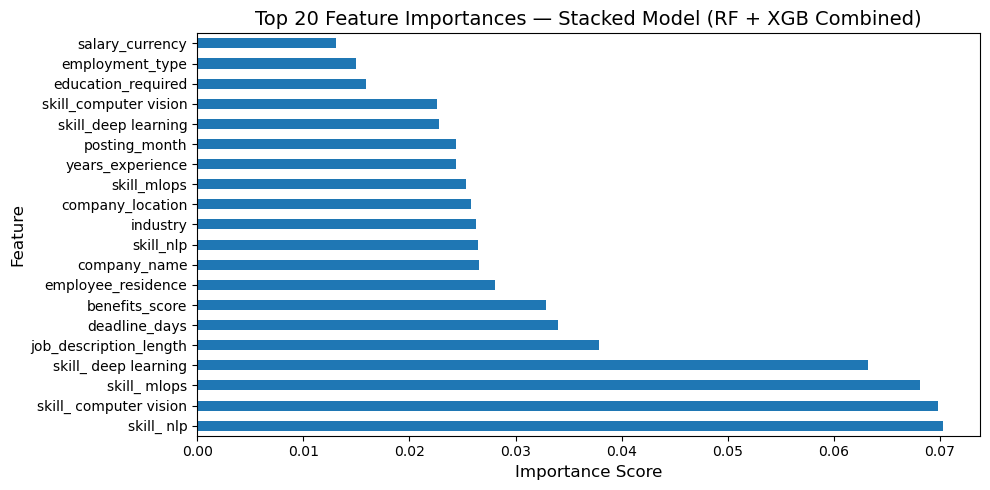

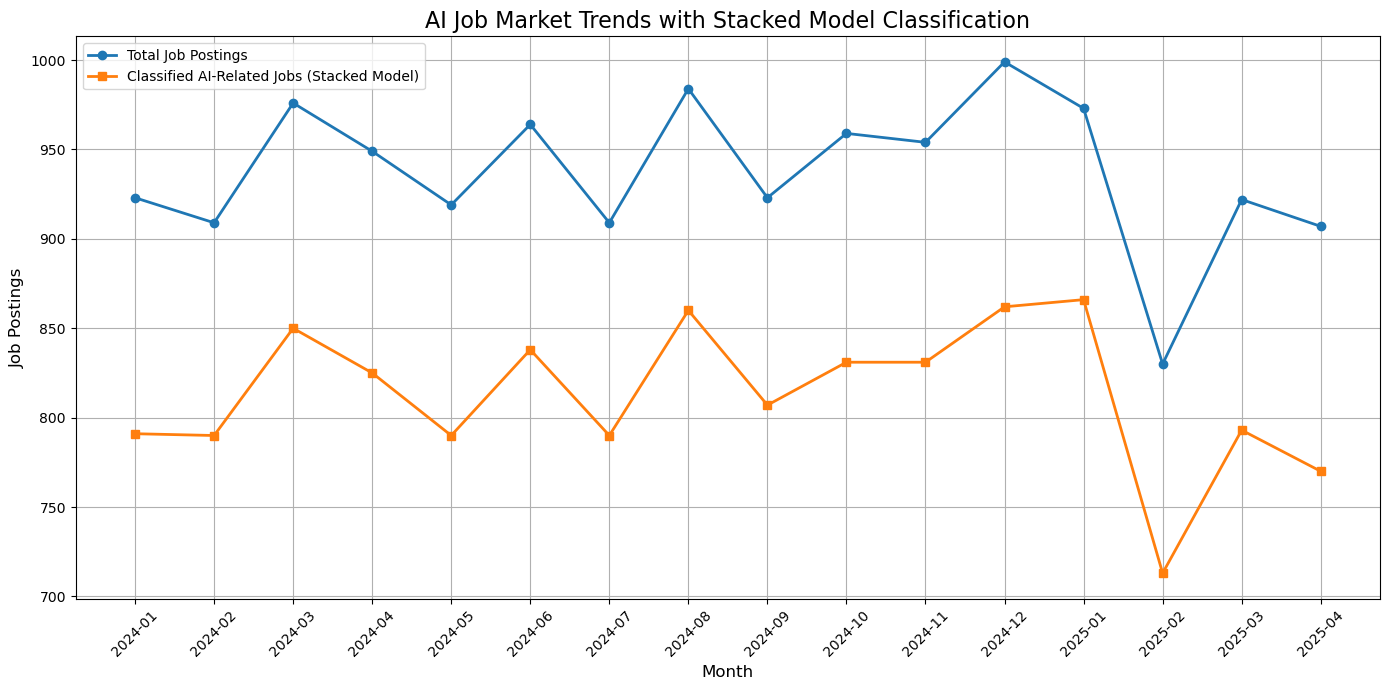

In [60]:
# STACKED MODEL FEATURE IMPORTANCE 

rf_imp = rf.feature_importances_ / rf.feature_importances_.sum()
xgb_imp = xgb.feature_importances_ / xgb.feature_importances_.sum()


stacked_importance = (0.5 * rf_imp) + (0.5 * xgb_imp)

stacked_series = pd.Series(stacked_importance, index=X.columns)

top_20_stacked = stacked_series.sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 5))
top_20_stacked.plot(kind="barh")

plt.title("Top 20 Feature Importances — Stacked Model (RF + XGB Combined)", fontsize=14)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance Score", fontsize=12)

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

def plot_stacked_model_trends(df, stacked_model, rf, xgb, X):
    df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')

    # Create a month column
    df['Month'] = df['posting_date'].dt.to_period('M').astype(str)
    monthly_counts = (
        df.groupby('Month')
        .size()
        .reset_index(name='job_postings')
        .sort_values('Month')
    )

    # Base model predictions
    rf_pred = rf.predict(X)
    xgb_pred = xgb.predict(X)

    stacked_inputs = np.column_stack((rf_pred, xgb_pred))

    df['stacked_pred'] = stacked_model.predict(stacked_inputs)

    monthly_pred = (
        df.groupby('Month')['stacked_pred']
        .sum()
        .reset_index(name='predicted_positive_impact')
        .sort_values('Month')
    )

    merged = monthly_counts.merge(monthly_pred, on='Month', how='left')


    # PLOT
    plt.figure(figsize=(14,7))

    # Actual job posting trend
    plt.plot(
        merged['Month'],
        merged['job_postings'],
        marker='o',
        label="Total Job Postings",
        linewidth=2
    )

    plt.plot(
        merged['Month'],
        merged['predicted_positive_impact'],
        marker='s',
        label="Classified AI-Related Jobs (Stacked Model)",
        linewidth=2
    )

    plt.title("AI Job Market Trends with Stacked Model Classification", fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Job Postings", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stack_train, y_train)
plot_stacked_model_trends(df, meta_model, rf, xgb, X)





17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


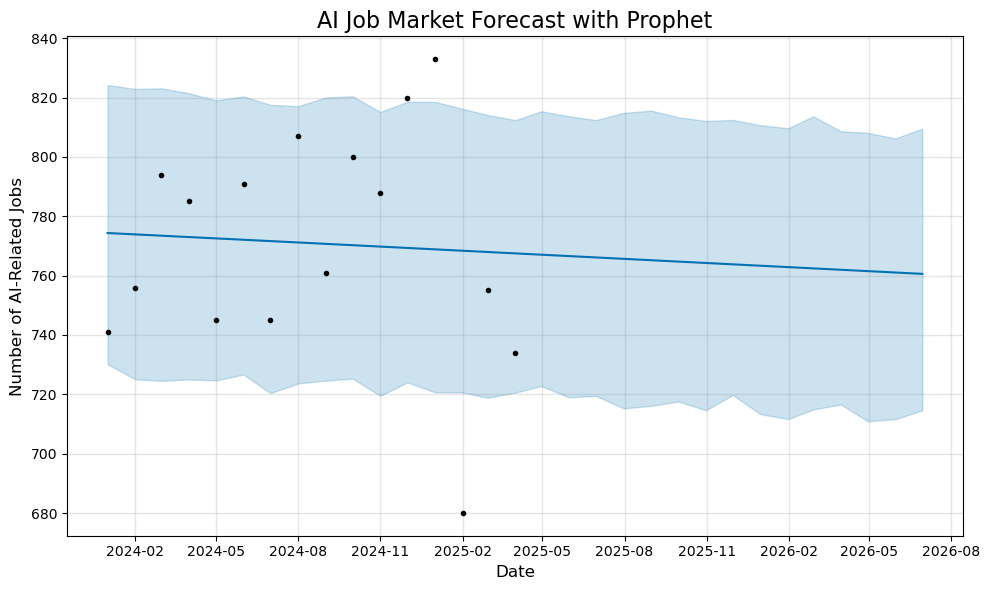

In [61]:
#-- Forecast Model --
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
df['Month'] = df['posting_date'].dt.to_period('M').astype(str)

monthly_ai_counts = (
    df.groupby('Month')['ai_impact_label']
    .sum()
    .reset_index(name='ai_job_postings')
)

monthly_ai_counts['ds'] = pd.to_datetime(monthly_ai_counts['Month'])
monthly_ai_counts['y'] = monthly_ai_counts['ai_job_postings']

prophet_df = monthly_ai_counts[['ds', 'y']]

model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=15, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("AI Job Market Forecast with Prophet", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of AI-Related Jobs", fontsize=12)
plt.tight_layout()
plt.show()

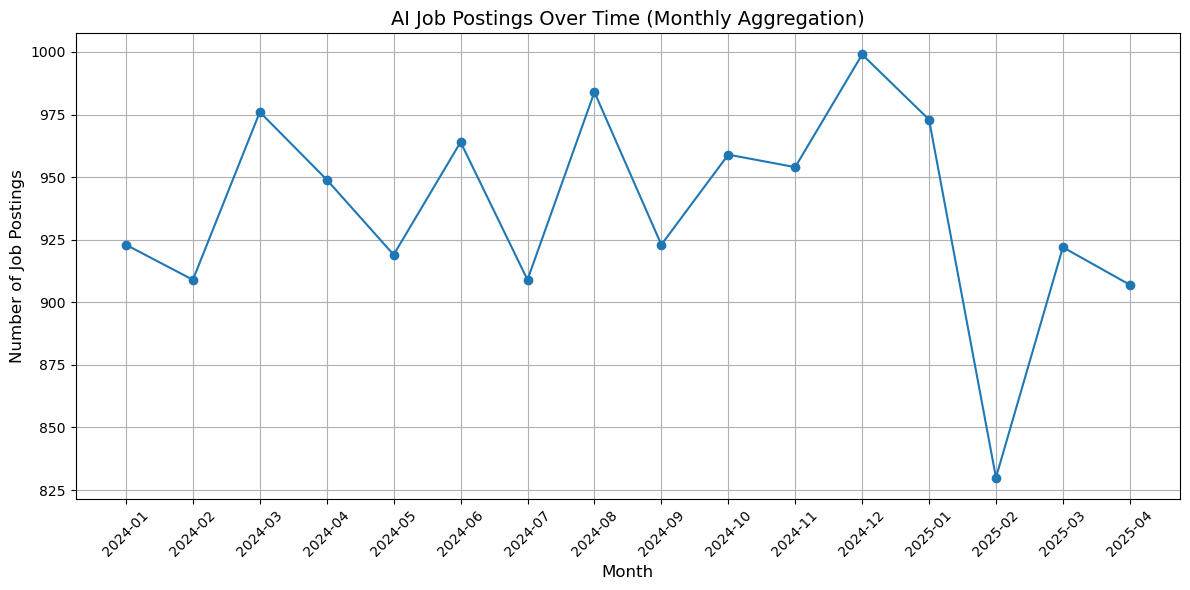

In [62]:
import matplotlib.pyplot as plt

df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
df['Month'] = df['posting_date'].dt.to_period('M').astype(str)
monthly_counts = df.groupby('Month').size().reset_index(name='job_postings')
monthly_counts = monthly_counts.sort_values('Month')

plt.figure(figsize=(12,6))
plt.plot(monthly_counts['Month'], monthly_counts['job_postings'], marker='o')

plt.title("AI Job Postings Over Time (Monthly Aggregation)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Job Postings", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


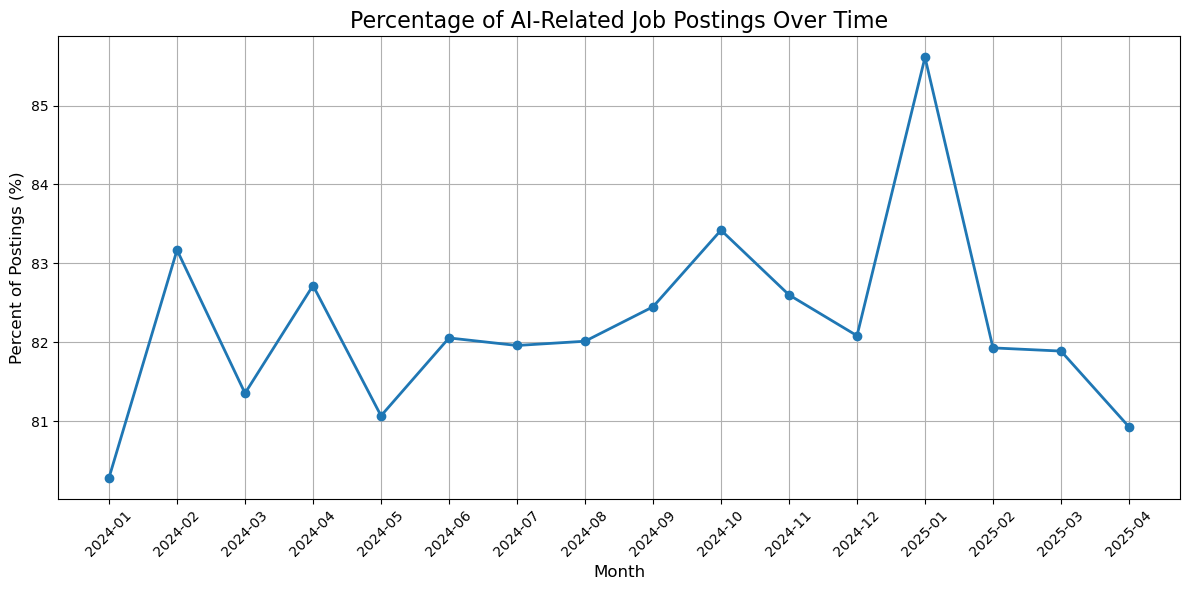

In [63]:
def plot_ai_percentage_over_time(df):
    df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
    df['Month'] = df['posting_date'].dt.to_period('M').astype(str)

    # Total per month
    total_monthly = df.groupby('Month').size().reset_index(name='total')

    # AI-related per month
    ai_monthly = (
        df.groupby('Month')['ai_impact_label']
        .sum()
        .reset_index(name='ai_related')
    )

    merged = total_monthly.merge(ai_monthly, on='Month')
    merged['percentage_ai'] = (merged['ai_related'] / merged['total']) * 100

    plt.figure(figsize=(12,6))
    plt.plot(merged['Month'], merged['percentage_ai'], marker='o', linewidth=2)

    plt.title("Percentage of AI-Related Job Postings Over Time", fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Percent of Postings (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ai_percentage_over_time(df)


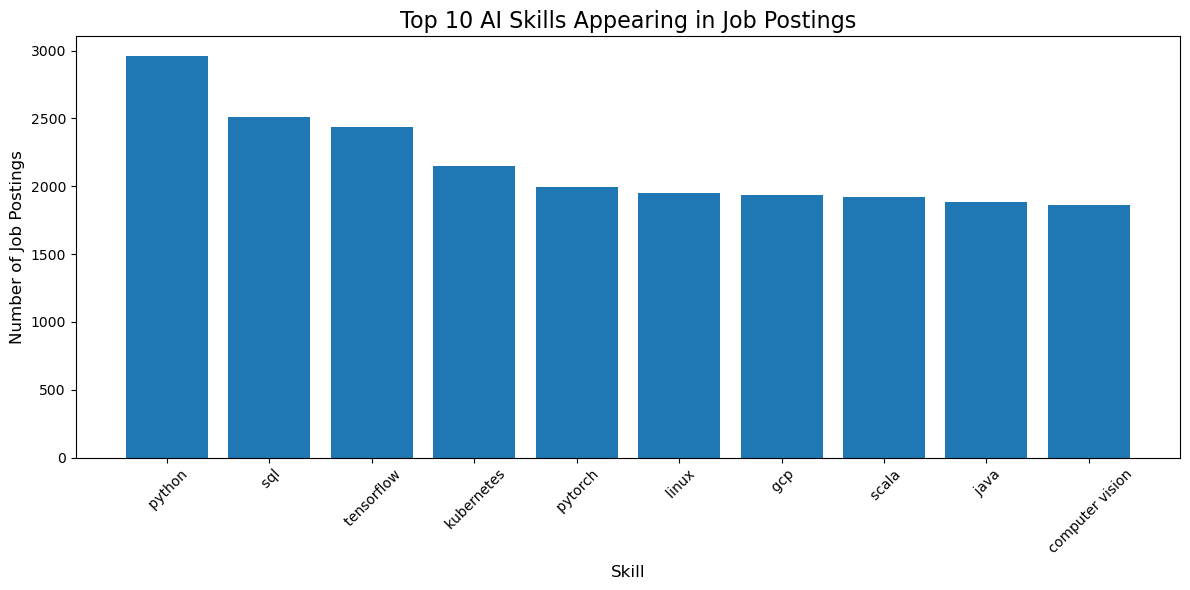

In [64]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_ai_skills_from_onehot(df, top_n=10):
    # 1. Find all skill_ columns created by CountVectorizer
    skill_cols = [col for col in df.columns if col.startswith("skill_")]
    if not skill_cols:
        raise ValueError("No skill_ columns found. Make sure you ran the CountVectorizer step.")

    # 2. Sum each column to get how many postings mention that skill
    skill_counts = df[skill_cols].sum().sort_values(ascending=False)

    # 3. Take the top N
    top_skills = skill_counts.head(top_n)

    # 4. Clean up labels (remove 'skill_' prefix)
    labels = [col.replace("skill_", "") for col in top_skills.index]
    counts = top_skills.values

    # 5. Plot
    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts)
    plt.title(f"Top {top_n} AI Skills Appearing in Job Postings", fontsize=16)
    plt.xlabel("Skill", fontsize=12)
    plt.ylabel("Number of Job Postings", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call it like this:
plot_top_ai_skills_from_onehot(df, top_n=10)


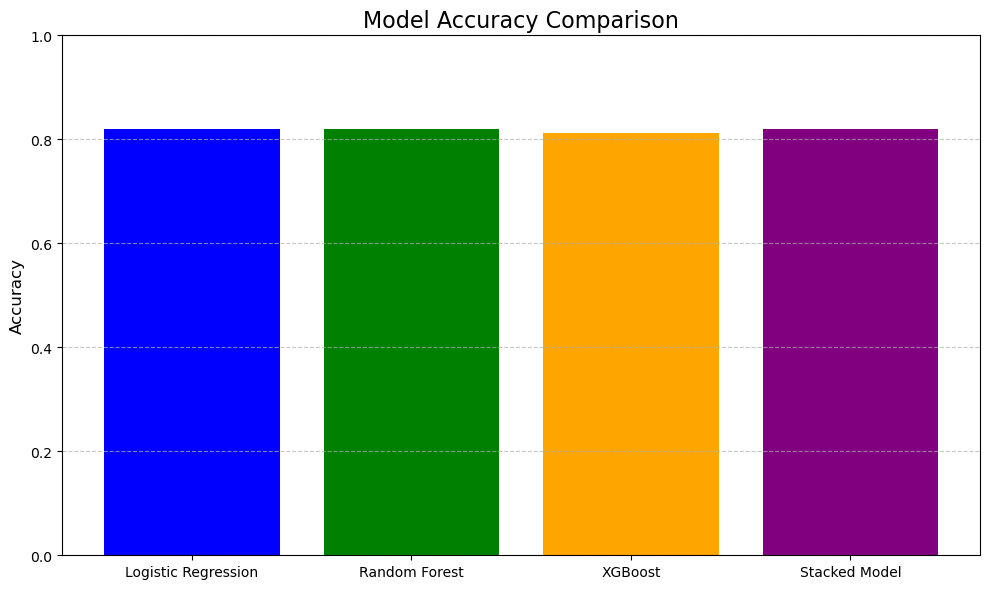

In [65]:
def plot_model_accuracy(log_reg_acc, rf_acc, xgb_acc, stacked_acc):
    models = ["Logistic Regression", "Random Forest", "XGBoost", "Stacked Model"]
    accuracies = [log_reg_acc, rf_acc, xgb_acc, stacked_acc]

    plt.figure(figsize=(10,6))
    plt.bar(models, accuracies, color=['blue','green','orange','purple'])

    plt.title("Model Accuracy Comparison", fontsize=16)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call this using the printed accuracies from your model eval
# Example:
plot_model_accuracy(
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, stacked_pred)
)
